## CSc 8830: Computer Vision - Assignment 2

Capture a 10 sec video footage using a camera of your choice. The footage should be taken with the camera in hand and you need to pan the camera slightly from left-right or right-left during the 10 sec duration. For all the images, operate at grayscale unless otherwise specified:

A video of 10 sec was recorded from a mobile camera with 1030p resolution and 30FPS frame rate.

#### 1. Pick any image frame from the 10 sec video footage. Pick a region of interest in the image making sure there is an EDGE in that region. Pick a 5 x 5 image patch in that region that constitutes the edge. Perform the steps of CANNY EDGE DETECTION manually and note the pixels that correspond to the EDGE. Compare the outcome with MATLAB or OpenCV or DepthAI’s Canny edge detection function.

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


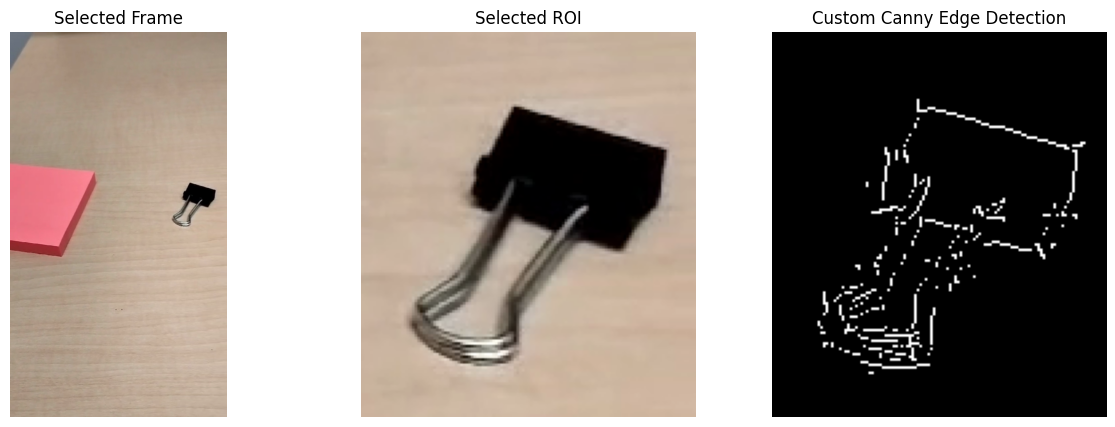

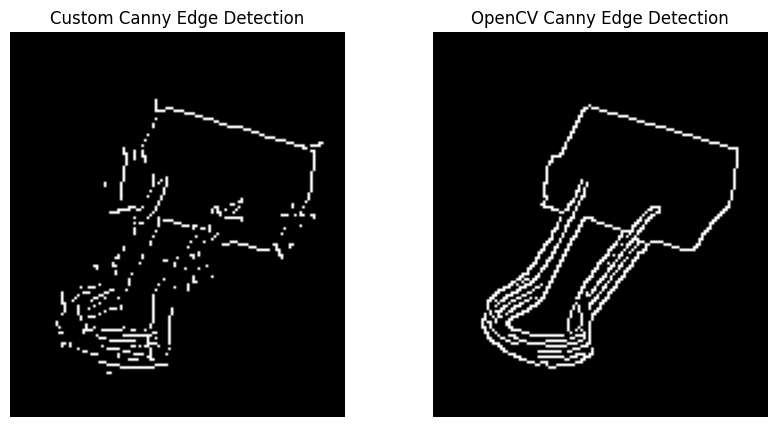

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for Canny Edge Detection
def custom_canny_edge_detection(image, low_threshold_ratio=0.05, high_threshold_ratio=0.09, sigma=5):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Gaussian blur
    blurred = cv2.GaussianBlur(gray_image, (5, 5), sigma)
    
    # Sobel filter
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    
    # Gradient magnitude and direction
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    magnitude *= 255.0 / magnitude.max()
    theta = np.arctan2(sobely, sobelx)
    
    # Non-maximum suppression
    angle = np.rad2deg(theta)
    angle[angle < 0] += 180
    
    suppressed = np.zeros_like(magnitude)
    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            orientation = angle[i, j]
            if (0 <= orientation < 22.5) or (157.5 <= orientation <= 180):
                neighbors = [magnitude[i, j-1], magnitude[i, j+1]]
            elif (22.5 <= orientation < 67.5):
                neighbors = [magnitude[i-1, j+1], magnitude[i+1, j-1]]
            elif (67.5 <= orientation < 112.5):
                neighbors = [magnitude[i-1, j], magnitude[i+1, j]]
            else:
                neighbors = [magnitude[i-1, j-1], magnitude[i+1, j+1]]
            if magnitude[i, j] >= max(neighbors):
                suppressed[i, j] = magnitude[i, j]
    
    # Double thresholding
    high_threshold = suppressed.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    
    strong_edges = (suppressed >= high_threshold)
    weak_edges = (suppressed >= low_threshold) & (suppressed < high_threshold)
    
    # Hysteresis
    edges = np.zeros_like(suppressed)
    edges[strong_edges] = 255
    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            if weak_edges[i, j]:
                if np.any(strong_edges[i-1:i+2, j-1:j+2]):
                    edges[i, j] = 255
    
    return edges

# Main function
def main():
    # Load video
    video_path = 'cv-ass-2_video.mp4'
    cap = cv2.VideoCapture(video_path)
    
    # Select frame
    frame_index = 75
    for i in range(frame_index + 1):
        ret, frame = cap.read()
    
    # Select ROI
    roi = select_roi(frame)
    
    # Custom Canny Edge Detection
    edge_map_custom = custom_canny_edge_detection(roi)
    
    # OpenCV Canny Edge Detection
    edge_map_opencv = cv2.Canny(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), 50, 255)
    
    # Display results
    display_results(frame, roi, edge_map_custom, edge_map_opencv)
    
    # Save results
    cv2.imwrite('custom_canny_edge_detection.png', edge_map_custom)
    cv2.imwrite('opencv_canny_edge_detection.png', edge_map_opencv)
    
    # Release video capture
    cap.release()

# Function to select ROI
def select_roi(frame):
    roi_x, roi_y, roi_width, roi_height = cv2.selectROI('Select ROI (Press "q" to Quit)', frame)
    return frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

# Function to display results
def display_results(frame, roi, edge_map_custom, edge_map_opencv):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Selected Frame')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title('Selected ROI')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(edge_map_custom, cmap='gray')
    plt.title('Custom Canny Edge Detection')
    plt.axis('off')
    
    plt.show()

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(edge_map_custom, cmap='gray')
    plt.title('Custom Canny Edge Detection')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(edge_map_opencv, cmap='gray')
    plt.title('OpenCV Canny Edge Detection')
    plt.axis('off')
    
    plt.show()

# Entry point
if __name__ == "__main__":
    main()


#### 2. Pick any image frame from the 10 sec video footage. Pick a region of interest in the image making sure there is a CORNER in that region. Pick a 5 x 5 image patch in that region that constitutes the edge. Perform the steps of HARRIS CORNER DETECTION manually and note the pixels that correspond to the CORNER. Compare the outcome with MATLAB or OpenCV or DepthAI’s  Harris corner detection function.

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


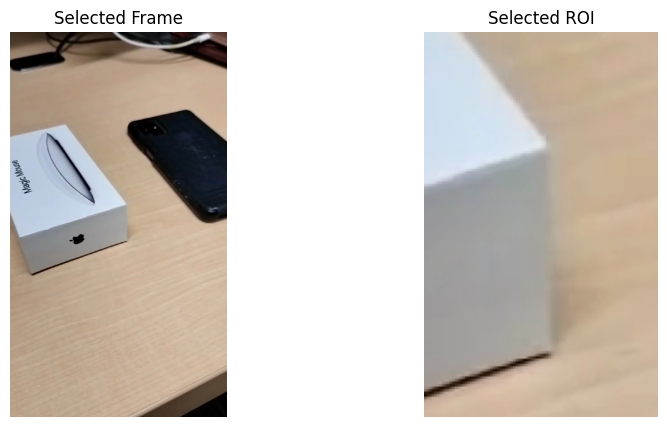

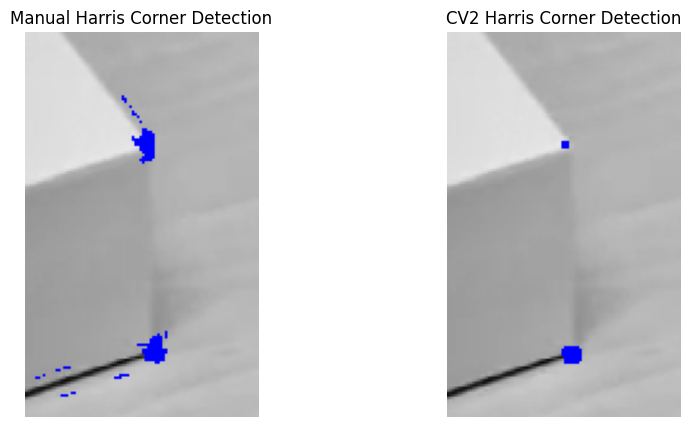

True

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_harris_corners(input_img, k, window_size, threshold):
    corner_list = []
    output_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_GRAY2RGB)
    offset = window_size // 2
    y_range = input_img.shape[0] - offset
    x_range = input_img.shape[1] - offset
    dx, dy = np.gradient(input_img)
    Ixx = dx ** 2
    Ixy = dy * dx
    Iyy = dy ** 2

    for y in range(offset, y_range):
        for x in range(offset, x_range):
            start_y, end_y = y - offset, y + offset + 1
            start_x, end_x = x - offset, x + offset + 1
            windowIxx, windowIxy, windowIyy = Ixx[start_y:end_y, start_x:end_x], \
                                               Ixy[start_y:end_y, start_x:end_x], \
                                               Iyy[start_y:end_y, start_x:end_x]
            Sxx, Sxy, Syy = windowIxx.sum(), windowIxy.sum(), windowIyy.sum()
            det = (Sxx * Syy) - (Sxy ** 2)
            trace = Sxx + Syy
            r = det - k * (trace ** 2)

            if r > threshold:
                corner_list.append([x, y, r])
                output_img[y, x] = (0, 0, 255)
    return corner_list, output_img

def harris_corner_detection(gray, ksize, k, threshold):
    dst = cv2.cornerHarris(gray, blockSize=ksize, ksize=ksize, k=k)
    dst_thresh = np.zeros_like(dst)
    dst_thresh[dst > threshold * dst.max()] = 255
    dst_thresh = cv2.dilate(dst_thresh, None)
    output_img = cv2.cvtColor(gray.copy(), cv2.COLOR_GRAY2RGB)
    output_img[dst_thresh > 0] = [0, 0, 255]
    return dst_thresh, output_img

# Function to select ROI using OpenCV's selectROI function
def select_roi(frame):
    roi_x, roi_y, roi_width, roi_height = cv2.selectROI('Select ROI (Press "q" to Quit)', frame)
    return frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

# Load the video
video_path = 'cv-ass-2_video.mp4'
cap = cv2.VideoCapture(video_path)

# Select a frame index
frame_index = 250

# Read the frame
for i in range(frame_index+1):
    ret, frame = cap.read()

# Select ROI
roi = select_roi(frame)

# Convert the ROI to grayscale
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Set parameters for Harris corner detection
k = 0.05  # Harris detector free parameter
window_size = 5  # Neighborhood size for corner detection
threshold = 10000.00  # Threshold for corner response

# Perform manual Harris corner detection on the image patch
corner_list, manual_corner_img = find_harris_corners(roi_gray, k, window_size, threshold)

# Perform Harris corner detection
corner_response, cv2_corner_img = harris_corner_detection(roi_gray, window_size, k, threshold=0.1)

# Display the selected frame with ROI
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Selected Frame')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.title('Selected ROI')
plt.axis('off')

plt.show()

# Display the results using Matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(manual_corner_img, cmap='gray')
plt.title('Manual Harris Corner Detection')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2_corner_img, cmap='gray')
plt.title('CV2 Harris Corner Detection')
plt.axis('off')

plt.show()

# Save the results
cv2.imwrite('manual_harris_corner_detection.png', manual_corner_img)
cv2.imwrite('opencv_harris_corner_detection.png', cv2_corner_img)


3. Consider an image pair from your footage where the images are separated by at least 2 seconds. Also ensure there is at least some overlap of scenes in the two images. 

    a. Pick a pixel (super-pixel patch as discussed in class) on image 1 and a corresponding pixel ((super-pixel patch as discussed in class)) on image 2 (the pixel on image 2 that corresponds to the same object area on image 1). Compute the SIFT feature for each of these 2 patches. Compute the sum of squared difference (SSD) value between the SIFT vector for these two pixels. Use MATLAB or Python or C++ implementation -- The MATLAB code for SIFT feature extraction and matching can be downloaded from here: https://www.cs.ubc.ca/~lowe/keypoints/ (Please first read the ReadMe document in the folder to find instructions to execute the code).

    b. Compute the Homography matrix between these two images using MATLAB or Python or C++ implementation. Compute its inverse.
You can make assumptions as necessary, however, justify them in your answers/description.


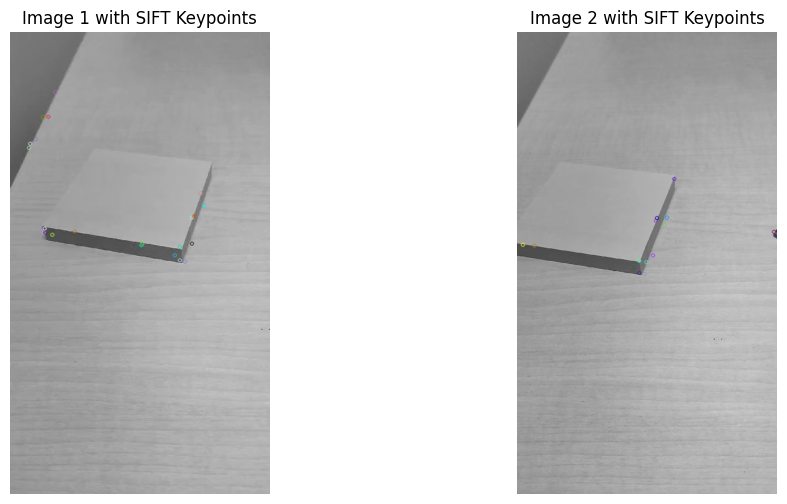

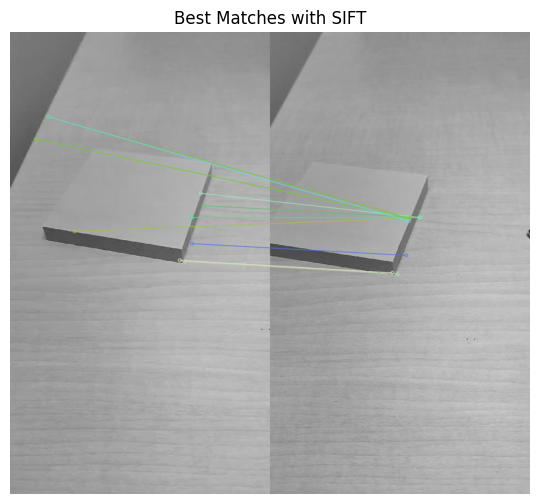

Sum of Squared Difference (SSD) between SIFT vectors: 4455.0


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_frames(video_path, time_threshold=2000, num_frames=2):
    cap = cv2.VideoCapture(video_path)
    prev_frame_time = None
    selected_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        current_frame_time = cap.get(cv2.CAP_PROP_POS_MSEC)

        if prev_frame_time is None or current_frame_time - prev_frame_time >= time_threshold:
            selected_frames.append((current_frame_time, frame))
            prev_frame_time = current_frame_time

            if len(selected_frames) == num_frames:
                break

    cap.release()
    return selected_frames

def save_frames(selected_frames):
    for i, (timestamp, frame) in enumerate(selected_frames):
        cv2.imwrite(f"frame_{i+1}.jpg", frame)

def detect_sift_keypoints(image):
    sift = cv2.SIFT_create()
    return sift.detectAndCompute(image, None)

def match_keypoints(descriptors1, descriptors2):
    bf = cv2.BFMatcher()
    return bf.match(descriptors1, descriptors2)

def draw_keypoints(image, keypoints):
    return cv2.drawKeypoints(image, keypoints, None)

def draw_matches(image1, keypoints1, image2, keypoints2, matches):
    return cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def display_images_with_keypoints(image1, image2, title1, title2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title(title1)
    ax[0].axis('off')
    ax[1].imshow(image2, cmap='gray')
    ax[1].set_title(title2)
    ax[1].axis('off')
    plt.show()

def display_matched_image(matched_img, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(matched_img)
    ax.set_title(title)
    ax.axis('off')
    plt.show()

def compute_sift_diff(matches, descriptors1, descriptors2):
    sift_diff = np.sum((descriptors1[matches[0].queryIdx] - descriptors2[matches[0].trainIdx]) ** 2)
    print("Sum of Squared Difference (SSD) between SIFT vectors:", sift_diff)

# Load the video
video_path = "cv-ass-2_video.mp4"

# Extract frames from the video
selected_frames = extract_frames(video_path)

# Save the selected frames as images
save_frames(selected_frames)

# Load the images
image1 = cv2.imread('frame_1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('frame_2.jpg', cv2.IMREAD_GRAYSCALE)

# Detect SIFT keypoints and descriptors in both images
keypoints1, descriptors1 = detect_sift_keypoints(image1)
keypoints2, descriptors2 = detect_sift_keypoints(image2)

# Match descriptors between the two images
matches = match_keypoints(descriptors1, descriptors2)

# Draw keypoints on the images
image_with_keypoints1 = draw_keypoints(image1, keypoints1)
image_with_keypoints2 = draw_keypoints(image2, keypoints2)

# Display images with keypoints
display_images_with_keypoints(image_with_keypoints1, image_with_keypoints2, 'Image 1 with SIFT Keypoints', 'Image 2 with SIFT Keypoints')

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw best matches
matched_img = draw_matches(image1, keypoints1, image2, keypoints2, matches[:10])

# Display matched image
display_matched_image(matched_img, 'Best Matches with SIFT')

# Compute SSD between SIFT vectors for the corresponding keypoints
compute_sift_diff(matches, descriptors1, descriptors2)

In [24]:
import cv2
import numpy as np

def select_frames_with_time_difference(video_path, time_difference_threshold=2000):
    cap = cv2.VideoCapture(video_path)
    prev_frame_time = None
    selected_frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        current_frame_time = cap.get(cv2.CAP_PROP_POS_MSEC)

        if prev_frame_time is None or current_frame_time - prev_frame_time >= time_difference_threshold:
            selected_frames.append((current_frame_time, frame))
            prev_frame_time = current_frame_time

            if len(selected_frames) == 2:
                break

    cap.release()

    if len(selected_frames) >= 2:
        print("Two frames with at least 2-second difference were selected.")
    else:
        print("Couldn't find two frames with at least 2-second difference.")

    return selected_frames

def save_frames_as_images(selected_frames):
    for i, (timestamp, frame) in enumerate(selected_frames):
        cv2.imwrite(f"frame_{i+1}.jpg", frame)

def load_images(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        images.append(image)
    return images

def find_keypoints_and_descriptors(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_descriptors(descriptors1, descriptors2):
    bf = cv2.BFMatcher()
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    best_matches = matches[:4]
    return best_matches

def compute_homography_matrix(pts1, pts2):
    homography_matrix, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC)
    return homography_matrix

def compute_inverse_homography_matrix(homography_matrix):
    inverse_homography_matrix = np.linalg.inv(homography_matrix)
    return inverse_homography_matrix

# Select frames from the video with at least a 2-second difference in timestamp
selected_frames = select_frames_with_time_difference("cv-ass-2_video.mp4")

# Save the selected frames as images
save_frames_as_images(selected_frames)

# Load the saved images
image_paths = ['frame_1.jpg', 'frame_2.jpg']
images = load_images(image_paths)

# Find keypoints and descriptors for each image
keypoints_list = []
descriptors_list = []
for image in images:
    keypoints, descriptors = find_keypoints_and_descriptors(image)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# Match descriptors between the two images
best_matches = match_descriptors(descriptors_list[0], descriptors_list[1])

# Get the keypoints for the best matches
pts1 = np.float32([keypoints_list[0][m.queryIdx].pt for m in best_matches]).reshape(-1, 1, 2)
pts2 = np.float32([keypoints_list[1][m.trainIdx].pt for m in best_matches]).reshape(-1, 1, 2)

# Compute the homography matrix
homography_matrix = compute_homography_matrix(pts1, pts2)

# Compute the inverse of the homography matrix
inverse_homography_matrix = compute_inverse_homography_matrix(homography_matrix)

# Print the homography matrix and its inverse
print("Homography Matrix:")
print(homography_matrix)
print("\nInverse of Homography Matrix:")
print(inverse_homography_matrix)


Two frames with at least 2-second difference were selected.
Homography Matrix:
[[-5.15969970e-01 -2.28519209e-01  2.56823547e+02]
 [-6.86768868e-01 -3.04164752e-01  3.41838531e+02]
 [-2.00904464e-03 -8.89790718e-04  1.00000000e+00]]

Inverse of Homography Matrix:
[[-1.36669475e+16  1.28836071e+16 -8.94119400e+17]
 [-2.54893927e+16  3.27274663e+16 -4.64123278e+18]
 [-5.01377325e+13  5.50043375e+13 -5.92605163e+15]]


#### 4. Implement an application that will compute and display the INTEGRAL image feed along with the RGB feed. You cannot use a built-in function such as “output = integral_image(input)”

[[     121      242      363 ...    65513    65654    65795]
 [     242      484      726 ...   131036   131318   131600]
 [     363      726     1089 ...   196581   197004   197427]
 ...
 [  116259   232592   349023 ... 65168637 65316333 65463986]
 [  116410   232893   349474 ... 65246228 65394098 65541925]
 [  116561   233195   349927 ... 65323855 65471899 65619900]]


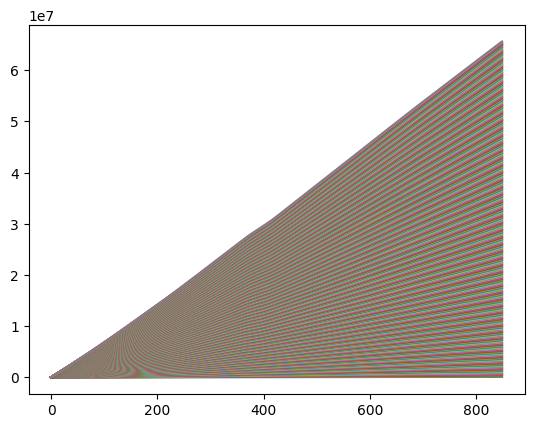

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

frame = cv2.imread("frame_1.jpg")

# Define function to compute integral image
def compute_integral_image(frame):
    gray_clr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    integral_image = np.cumsum(np.cumsum(gray_clr, axis=1), axis=0)
    return integral_image

integral_image = compute_integral_image(frame)

print(integral_image)
np.savetxt('integral_image.txt', integral_image, fmt='%d')
plt.plot(integral_image)
plt.savefig("integral_image.jpg")
plt.show()


In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import depthai  # Import depthai library

# Create DepthAI pipeline
pipeline = depthai.Pipeline()

# Define sources and output for the pipeline
cam_rgb = pipeline.createColorCamera()
xout_rgb = pipeline.createXLinkOut()
xout_integral = pipeline.createXLinkOut()

# Set properties for the color camera
cam_rgb.setPreviewSize(300, 300)
cam_rgb.setResolution(depthai.ColorCameraProperties.SensorResolution.THE_1080_P)
cam_rgb.setInterleaved(False)
cam_rgb.setColorOrder(depthai.ColorCameraProperties.ColorOrder.RGB)

# Output stream for RGB frames
xout_rgb.setStreamName("rgb")

# Output stream for integral image
xout_integral.setStreamName("integral")

# Linking color camera to output streams
cam_rgb.preview.link(xout_rgb.input)
cam_rgb.preview.link(xout_integral.input)

# Connect to the device
with depthai.Device(pipeline) as device:
    # Start the pipeline
    device.startPipeline()

    # Define function to compute integral image
    def compute_integral_image(frame):
        gray_clr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        integral_image = np.cumsum(np.cumsum(gray_clr, axis=1), axis=0)
        return integral_image

    # Main loop to capture and process frames
    while True:
        # Get the frames from the output streams
        in_rgb = device.getOutputQueue(name="rgb", maxSize=1).get()
        in_integral = device.getOutputQueue(name="integral", maxSize=1).get()

        # Read and display RGB frame
        frame_rgb = in_rgb.getCvFrame()
        cv2.imshow("RGB Stream", frame_rgb)

        # Compute integral image and display
        integral_image = compute_integral_image(frame_rgb)
        cv2.imshow("Integral Image", integral_image.astype(np.uint8))

        # Check for 'q' key press to exit
        if cv2.waitKey(1) == ord('q'):
            break

    # Release resources
    cv2.destroyAllWindows()


/var/folders/cv/flgh8s7960bc7q380pyn0c6m0000gn/T/ipykernel_41341/689367140.py:33: DeprecationWarning: Device(pipeline) starts the pipeline automatically. Use Device() and startPipeline(pipeline) otherwise
  device.startPipeline()


##### 5. Implement the image stitching for a 360 degree panoramic output. This should function in real-time. You can use any type of features. You can use built-in libraries/tools provided by OpenCV or DepthAI API. You cannot use any built-in function that does output = image_stitch(image1, image2). You are supposed to implement the image_stitch() function

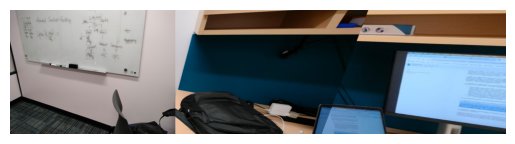

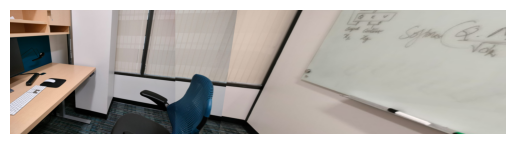

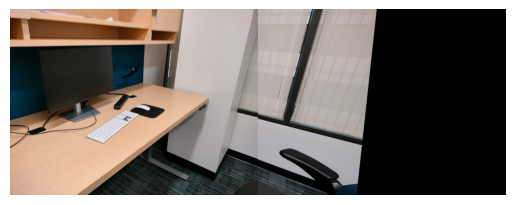

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(img1, img2):
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    
    keypoints1, descriptors1 = sift.detectAndCompute(gray_img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray_img2, None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good_matches.append(m)
    good_matches = np.asarray(good_matches)
    
    if len(good_matches) >= 4:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        warped_img1 = cv2.warpPerspective(img1, H, (img2.shape[1] + img1.shape[1], img2.shape[0]))
        
        stitched_img = warped_img1.copy()
        stitched_img[0:img2.shape[0], 0:img2.shape[1]] = img2
        
        return stitched_img
    else:
        raise AssertionError("Insufficient good matches for stitching.")

def stitch_panoramic_images(image_paths):
    images = [cv2.imread(path) for path in image_paths]
    panorama = images[0]
    for image in images[1:]:
        panorama = stitch_images(panorama, image)
    return panorama

def display_and_save_panorama(panorama, output_path):
    cv2.imwrite(output_path, panorama)
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Stitch images covering 360 degrees (1, 2, 3)
panorama1 = stitch_panoramic_images([f'pan-images/trends-lab/img{i}.jpeg' for i in range(1, 4)])
display_and_save_panorama(panorama1, 'panoramic_output1.jpg')

# Stitch images covering 360 degrees (4, 5, 6)
panorama2 = stitch_panoramic_images([f'pan-images/trends-lab/img{i}.jpeg' for i in range(4, 7)])
display_and_save_panorama(panorama2, 'panoramic_output2.jpg')

# Stitch images covering 360 degrees (6, 7)
panorama3 = stitch_panoramic_images([f'pan-images/trends-lab/img{i}.jpeg' for i in range(6, 8)])
display_and_save_panorama(panorama3, 'panoramic_output3.jpg')
